In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

import pointpats 
from pointpats import PointPattern
import shapely
from shapely.wkt import loads  
from shapely.geometry import Point
from libpysal.cg import shapely_ext
from pointpats import PoissonPointProcess as ppp_csr
from pointpats import window
from pointpats.window import poly_from_bbox, as_window, Window, to_ccf
import pointpats.quadrat_statistics as qs
from pointpats.centrography import hull, mbr, mean_center, weighted_mean_center, manhattan_median, std_distance,euclidean_median,ellipse
import pysal as ps #derive spatial geometry features 
import libpysal as lps


# to add basemap
!pip install contextily
import contextily
import folium
from folium import plugins
from folium.plugins import HeatMap, MarkerCluster, FastMarkerCluster

from matplotlib import colors
from matplotlib.colors import ListedColormap
from matplotlib.colors import BoundaryNorm
from libpysal import weights
from pysal.explore import esda
from splot import esda as esdaplot  #for an easy way to plot cluster mapb
import numba 

import warnings
warnings.simplefilter('ignore') 

/opt/conda/lib/python3.11/site-packages/spaghetti/network.py:41: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


In [3]:
clbr_proj = gpd.read_file('closed_branches_all_27700.shp')

In [4]:
clbr_proj.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5611 entries, 0 to 5610
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   id          5611 non-null   int64   
 1   brand_full  5611 non-null   object  
 2   brand_shor  5611 non-null   object  
 3   branch_typ  5611 non-null   object  
 4   region      5608 non-null   object  
 5   postcode    5584 non-null   object  
 6   long_wgs84  5611 non-null   float64 
 7   lat_wgs84   5611 non-null   float64 
 8   status      5611 non-null   object  
 9   close_year  5611 non-null   float64 
 10  po_dist     5611 non-null   int64   
 11  geometry    5611 non-null   geometry
dtypes: float64(3), geometry(1), int64(2), object(6)
memory usage: 526.2+ KB


In [5]:
# change 'close_year' column to integer type
clbr_proj['close_year'] = clbr_proj['close_year'].astype(int)

# Group by year and count closures
clbr_years = clbr_proj.groupby('close_year').size()

In [6]:
clbr_years

close_year
2015    315
2016    485
2017    805
2018    769
2019    436
2020    156
2021    781
2022    855
2023    640
2024    369
dtype: int64

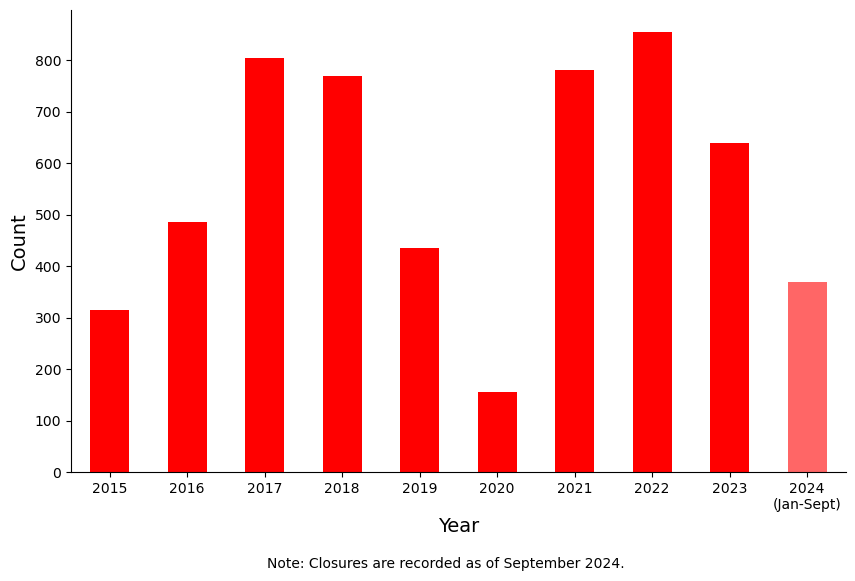

In [7]:
# Plot the bar graph
plt.figure(figsize=(10, 6))

# Set up bar colors (different color for 2024)
colors = ['red' if year != 2024 else '#ff6666' for year in clbr_years.index] 

clbr_years.plot.bar(color=colors)

#plt.title('UK Bank Branch Closures', fontsize=18) - add to figure caption
plt.xlabel('Year', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=0)

# Custom x-axis tick labels
x_labels = [
    str(year) if year != 2024 else "2024\n(Jan-Sept)"  # Add "Jan-Sept" beneath 2024
    for year in clbr_years.index
]
plt.gca().set_xticklabels(x_labels, rotation=0, ha="center")

plt.gca().spines['right'].set_visible(False)     
plt.gca().spines['top'].set_visible(False)

# Add note below the graph
plt.figtext(
    0.5, -0.05,  # Position the text below the graph
    "Note: Closures are recorded as of September 2024.",
    wrap=True, horizontalalignment='center', fontsize=10)

#save as file
plt.savefig("figures/bar_clbrcount.png", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

In [8]:
clbr_geo = clbr_proj.to_crs(epsg=4326)

In [9]:
clbr_geo

id         brand_full brand_shor branch_typ            region  \
0         4  Allied Irish Bank        AIB     Branch  Northern Ireland   
1         6  Allied Irish Bank        AIB     Branch  Northern Ireland   
2         7  Allied Irish Bank        AIB     Branch  Northern Ireland   
3         8  Allied Irish Bank        AIB     Branch  Northern Ireland   
4         9  Allied Irish Bank        AIB     Branch  Northern Ireland   
...     ...                ...        ...        ...               ...   
5606  10647       Virgin Money         VM     Branch          Scotland   
5607  10656       Virgin Money         VM     Branch          Scotland   
5608  10683       Virgin Money         VM     Branch        South West   
5609  10700       Virgin Money         VM     Branch          Scotland   
5610  11124             Coutts         CT     Branch              None   

      postcode  long_wgs84  lat_wgs84  status  close_year  po_dist  \
0      BT1 2AL   -5.926691  54.599923  Closed        2017       54   
1     BT11 9BY   -5.988669  54.573287  Closed        2017      371   
2     BT20 4BA   -5.668490  54.660400  Closed        2021       47   
3     BT23 7HS   -5.694836  54.592691  Closed        2017      203   
4     BT28 1AG   -6.044236  54.511319  Closed        2021      247   
...        ...         ...        ...     ...         ...      ...   
5606  PA31 8LL   -5.435720  56.036790  Closed        2023      264   
5607   DG8 6NL   -4.483220  54.959530  Closed        2023      219   
5608   SN1 1PW   -1.782130  51.558600  Closed        2023      315   
5609  AB53 4AA   -2.460170  57.537290  Closed        2023      141   
5610   NR6 6JA    1.277334  52.669889  Closed        2024      932   

                       geometry  
0     POINT (-5.92669 54.59992)  
1     POINT (-5.98867 54.57329)  
2     POINT (-5.66849 54.66040)  
3     POINT (-5.69484 54.59269)  
4     POINT (-6.04424 54.51132)  
...                         ...  
5606  POINT (-5.43572 56.03679)  
5607  POINT (-4.48322 54.95953)  
5608  POINT (-1.78213 51.55860)  
5609  POINT (-2.46017 57.53729)  
5610   POINT (1.27733 52.66989)  

[5611 rows x 12 columns]

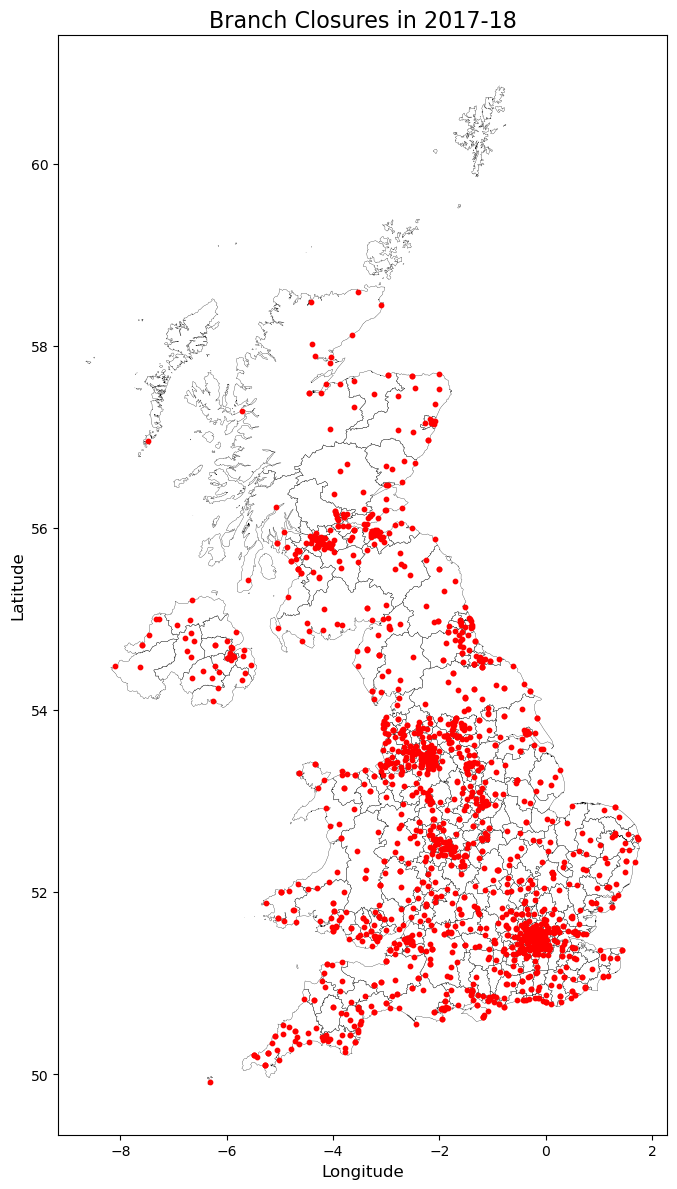

In [10]:
UK_LAD_base = gpd.read_file('LAD_MAY_2024_UK_BUC.shp')
uklad_geo = UK_LAD_base.to_crs(epsg=4326)

# Filter for specific years 2017 and 2018
clbr_2017_18 = clbr_geo[clbr_geo['close_year'].isin([2017, 2018])]

# Plot using Matplotlib
fig, ax = plt.subplots(figsize=(12, 12))

#Plot the LAD boundaries
uklad_geo.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.2)

# Plot the points
clbr_2017_18.plot(ax=ax, color='red', markersize=10)


# Add title and axis labels
ax.set_title("Branch Closures in 2017-18", fontsize=16)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

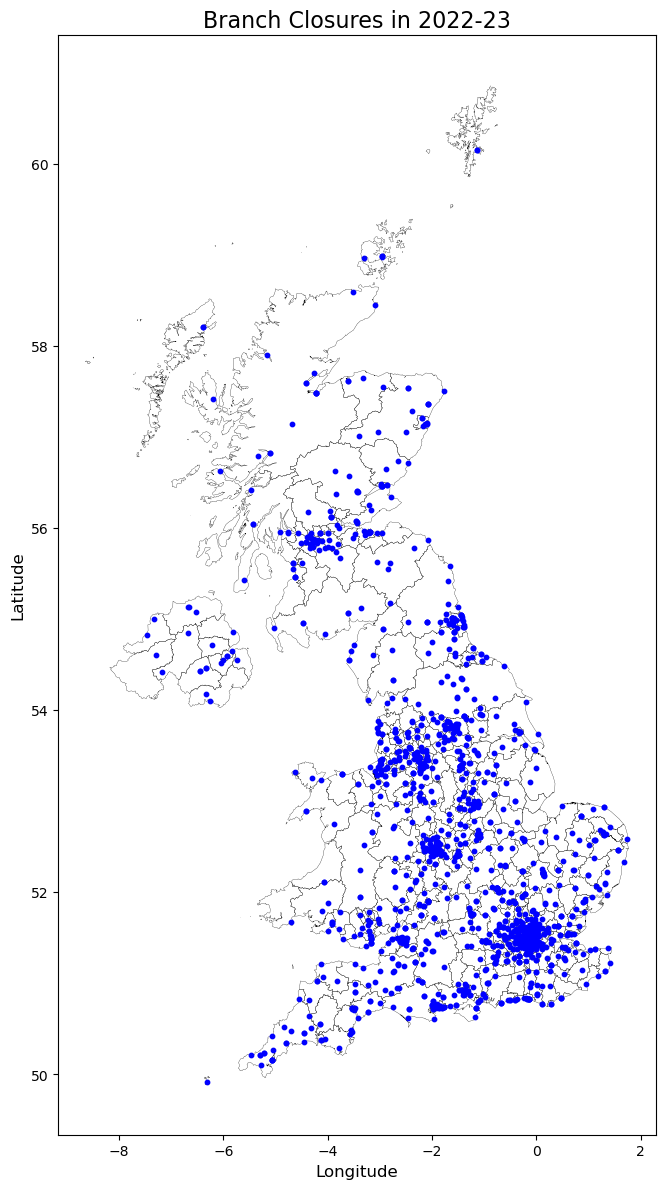

In [11]:
UK_LAD_base = gpd.read_file('LAD_MAY_2024_UK_BUC.shp')
uklad_geo = UK_LAD_base.to_crs(epsg=4326)

# Filter for specific years 2022 and 2023
clbr_2022_23 = clbr_geo[clbr_geo['close_year'].isin([2022, 2023])]

# Plot using Matplotlib
fig, ax = plt.subplots(figsize=(12, 12))

#Plot the LAD boundaries
uklad_geo.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.2)

# Plot the points
clbr_2022_23.plot(ax=ax, color='blue', markersize=10)


# Add title and axis labels
ax.set_title("Branch Closures in 2022-23", fontsize=16)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

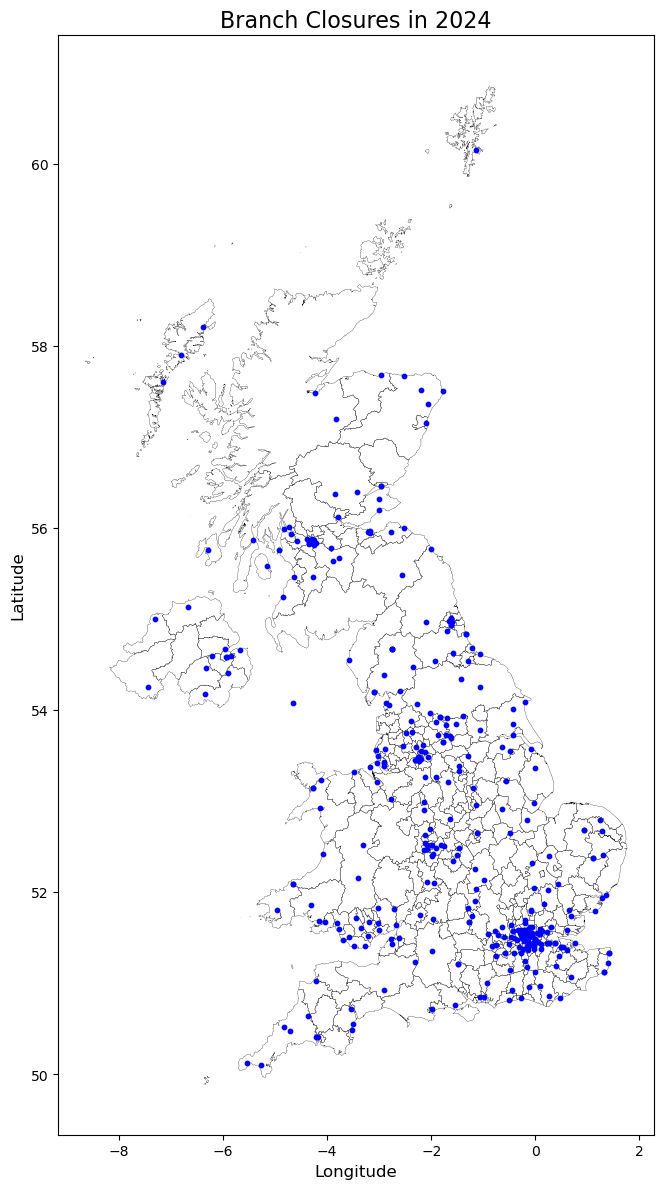

In [12]:
UK_LAD_base = gpd.read_file('LAD_MAY_2024_UK_BUC.shp')
uklad_geo = UK_LAD_base.to_crs(epsg=4326)

# Filter for 2024
clbr_2024 = clbr_geo[clbr_geo['close_year'] == 2024]

# Plot using Matplotlib
fig, ax = plt.subplots(figsize=(12, 12))

#Plot the LAD boundaries
uklad_geo.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.2)

# Plot the points
clbr_2024.plot(ax=ax, color='blue', markersize=10)


# Add title and axis labels
ax.set_title("Branch Closures in 2024", fontsize=16)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

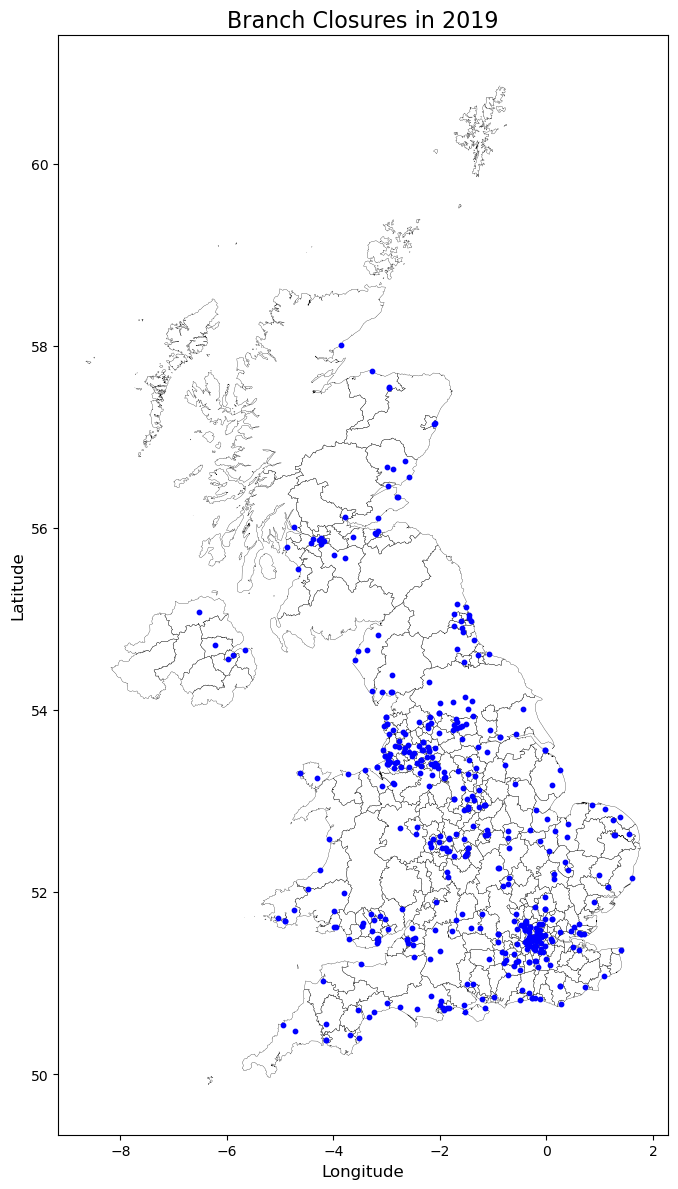

In [13]:
UK_LAD_base = gpd.read_file('LAD_MAY_2024_UK_BUC.shp')
uklad_geo = UK_LAD_base.to_crs(epsg=4326)

# Filter for 2022 and 2023
clbr_2019 = clbr_geo[clbr_geo['close_year'] == 2019]

# Plot using Matplotlib
fig, ax = plt.subplots(figsize=(12, 12))

#Plot the LAD boundaries
uklad_geo.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.2)

# Plot the points
clbr_2019.plot(ax=ax, color='blue', markersize=10)


# Add title and axis labels
ax.set_title("Branch Closures in 2019", fontsize=16)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

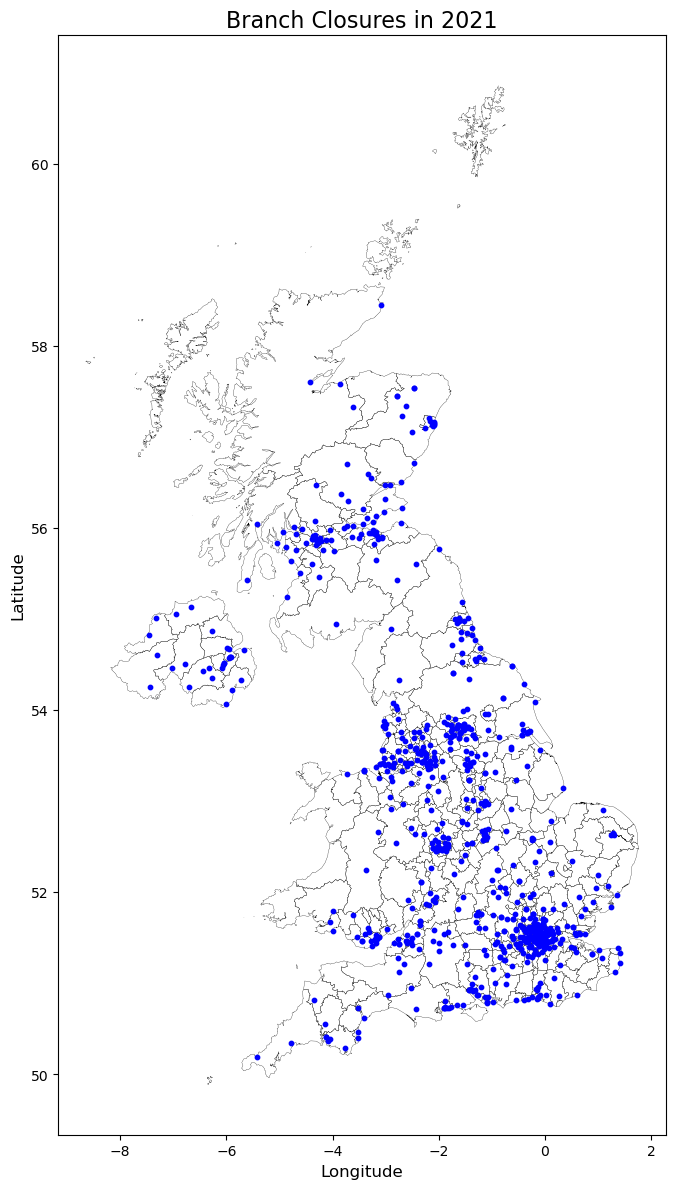

In [14]:
UK_LAD_base = gpd.read_file('LAD_MAY_2024_UK_BUC.shp')
uklad_geo = UK_LAD_base.to_crs(epsg=4326)

# Filter for 2022 and 2023
clbr_2021= clbr_geo[clbr_geo['close_year'] == 2021]

# Plot using Matplotlib
fig, ax = plt.subplots(figsize=(12, 12))

#Plot the LAD boundaries
uklad_geo.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.2)

# Plot the points
clbr_2021.plot(ax=ax, color='blue', markersize=10)


# Add title and axis labels
ax.set_title("Branch Closures in 2021", fontsize=16)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

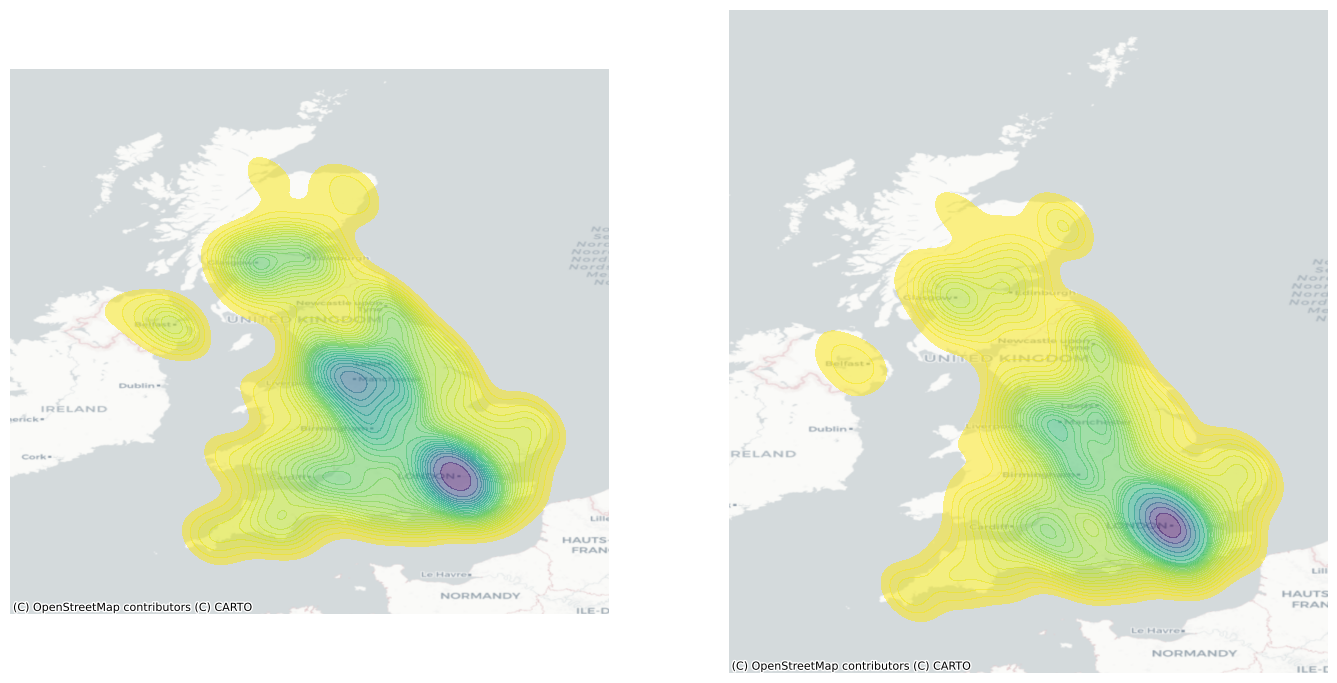

In [15]:
# Set up figure and axis
f, ax = plt.subplots(1, 2, figsize=(17, 11))

# Generate and add KDE with a shading of 30 gradients
# coloured contours, 55% of transparency,
# and the reverse viridis colormap
# complete the code below
sns.kdeplot(
    x="long_wgs84",
    y="lat_wgs84",
    data=clbr_geo[clbr_geo['close_year'].isin([2017, 2018])],
    n_levels=30,
    bw_adjust=0.8,
    shade=True,
    alpha=0.55,
    cmap="viridis_r",
    ax=ax[0]
)

sns.kdeplot(
    x="long_wgs84",
    y="lat_wgs84",
    data=clbr_geo[clbr_geo['close_year'].isin([2022, 2023])],
    n_levels=30,
    bw_adjust=0.8,
    shade=True,
    alpha=0.55,
    cmap="viridis_r",
    ax=ax[1]
)
# Add basemap
contextily.add_basemap(
    ax[0], crs="EPSG:4326", source=contextily.providers.CartoDB.Positron
)
# Add basemap
contextily.add_basemap(
    ax[1], crs="EPSG:4326", source=contextily.providers.CartoDB.Positron
)

ax[0].axis('off') #don't plot the axes (bounding box)
ax[1].axis('off') #don't plot the axes (bounding box)

#ax[0].set_title('KDE Closed Branches (2017-2018)', fontsize=16)  #axis title
#ax[1].set_title('KDE Closed Branches (2022-2023)', fontsize=16)  #axis title


#save as file
plt.savefig("figures/clbr_KDEmaps.png", dpi=300, bbox_inches='tight', facecolor='white')

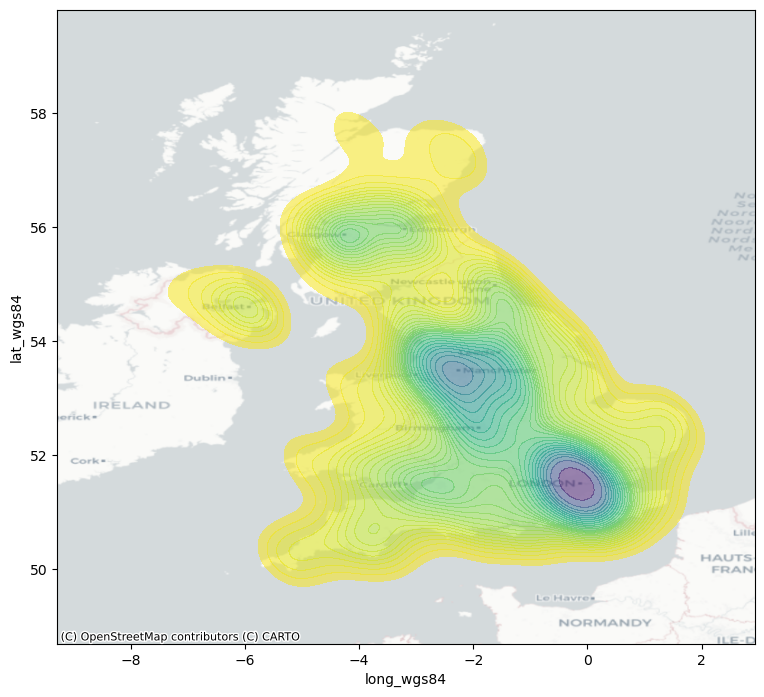

In [16]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))

# Generate and add KDE with a shading of 30 gradients
# coloured contours, 55% of transparency,
# and the reverse viridis colormap
# complete the code below
sns.kdeplot(
    x="long_wgs84",
    y="lat_wgs84",
    data=clbr_geo[clbr_geo['close_year'].isin([2017, 2018])],
    n_levels=30,
    bw_adjust=0.8,
    shade=True,
    alpha=0.55,
    cmap="viridis_r",
)
# Add basemap
contextily.add_basemap(
    ax, crs="EPSG:4326", source=contextily.providers.CartoDB.Positron
)

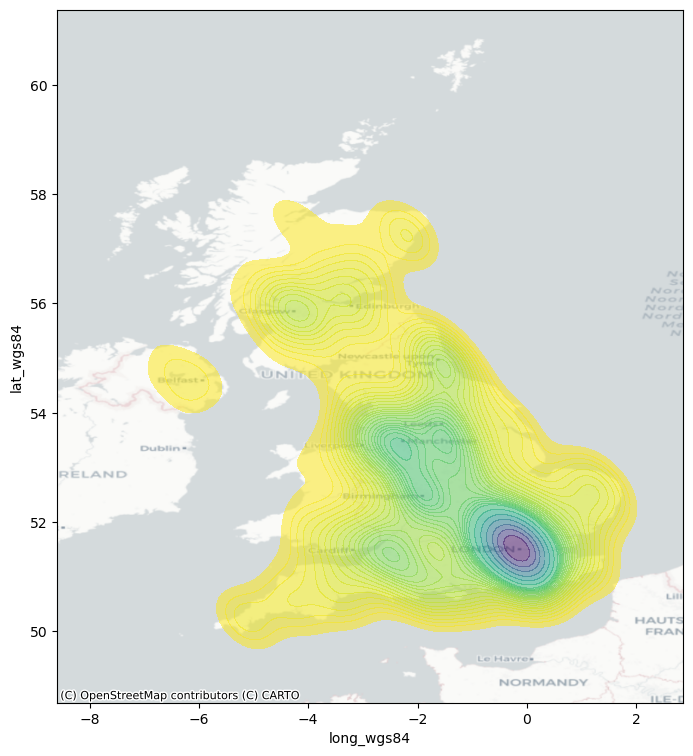

In [17]:
# Set up figure and axis
f, ax1 = plt.subplots(1, figsize=(9, 9))

# Generate and add KDE with a shading of 30 gradients
# coloured contours, 55% of transparency,
# and the reverse viridis colormap
# complete the code below
sns.kdeplot(
    x="long_wgs84",
    y="lat_wgs84",
    data=clbr_geo[clbr_geo['close_year'].isin([2022, 2023])],
    n_levels=30,
    bw_adjust=0.8,
    shade=True,
    alpha=0.55,
    cmap="viridis_r",
)
# Add basemap
contextily.add_basemap(
    ax1, crs="EPSG:4326", source=contextily.providers.CartoDB.Positron
)

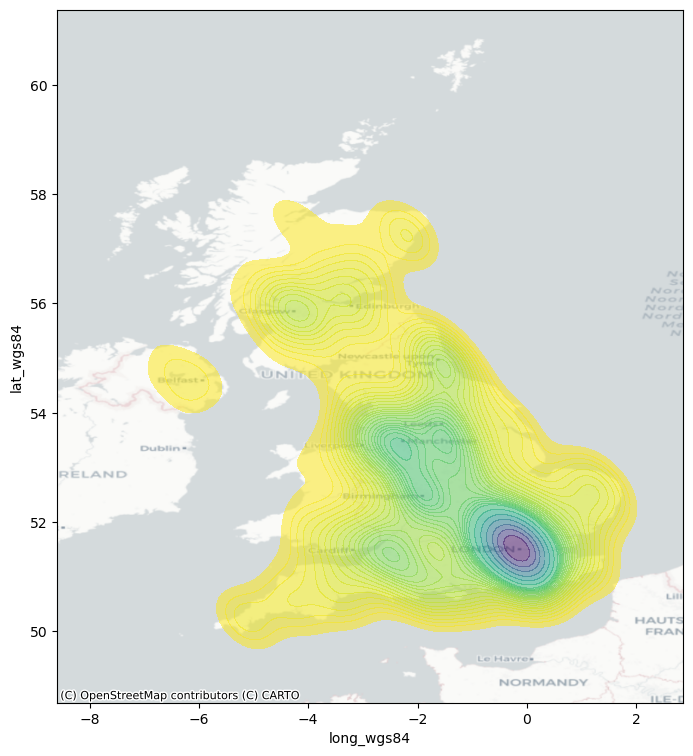

In [18]:
# Set up figure and axis
f, ax1 = plt.subplots(1, figsize=(9, 9))

# Generate and add KDE with a shading of 30 gradients
# coloured contours, 55% of transparency,
# and the reverse viridis colormap
# complete the code below
sns.kdeplot(
    x="long_wgs84",
    y="lat_wgs84",
    data=clbr_geo[clbr_geo['close_year'].isin([2022, 2023])],
    n_levels=30,
    bw_adjust=0.8,
    shade=True,
    alpha=0.55,
    cmap="viridis_r",
)
# Add basemap
contextily.add_basemap(
    ax1, crs="EPSG:4326", source=contextily.providers.CartoDB.Positron
)

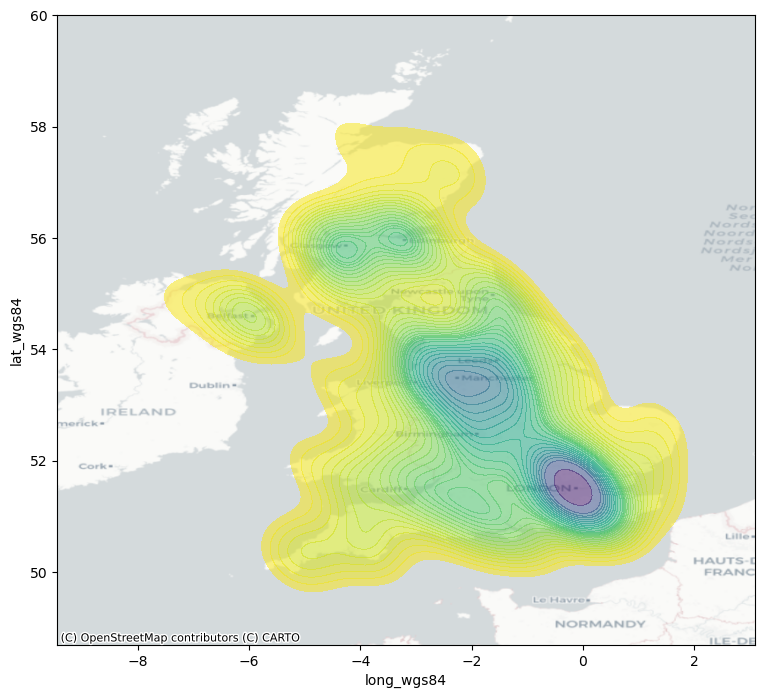

In [19]:
# Set up figure and axis
f, ax3 = plt.subplots(1, figsize=(9, 9))

# Generate and add KDE with a shading of 30 gradients
# coloured contours, 55% of transparency,
# and the reverse viridis colormap
# complete the code below
sns.kdeplot(
    x="long_wgs84",
    y="lat_wgs84",
    data=clbr_geo[clbr_geo['close_year'].isin([2017])],
    n_levels=30,
    bw_adjust=0.8,
    shade=True,
    alpha=0.55,
    cmap="viridis_r",
)
# Add basemap
contextily.add_basemap(
    ax3, crs="EPSG:4326", source=contextily.providers.CartoDB.Positron
)

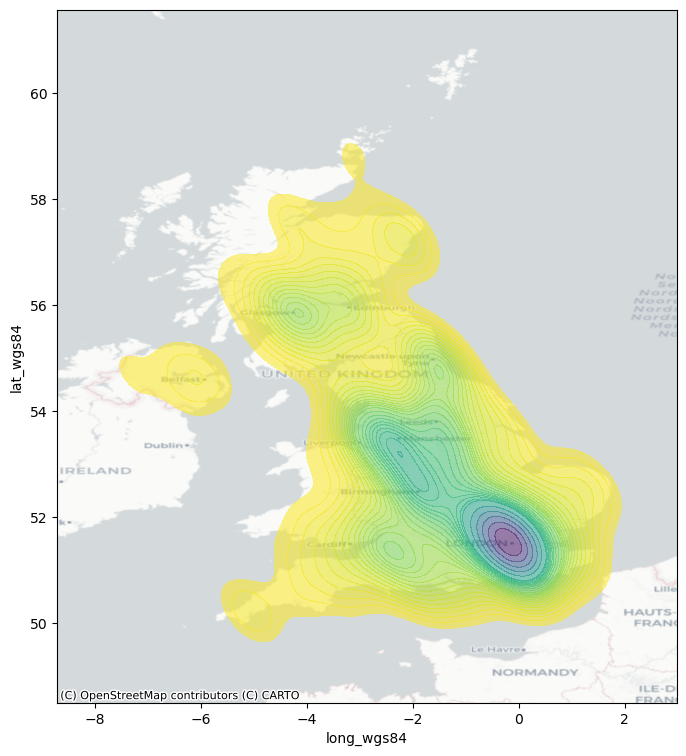

In [20]:
# Set up figure and axis
f, ax3 = plt.subplots(1, figsize=(9, 9))

# Generate and add KDE with a shading of 30 gradients
# coloured contours, 55% of transparency,
# and the reverse viridis colormap
# complete the code below
sns.kdeplot(
    x="long_wgs84",
    y="lat_wgs84",
    data=clbr_geo[clbr_geo['close_year'].isin([2022])],
    n_levels=30,
    bw_adjust=0.8,
    shade=True,
    alpha=0.55,
    cmap="viridis_r",
)
# Add basemap
contextily.add_basemap(
    ax3, crs="EPSG:4326", source=contextily.providers.CartoDB.Positron
)

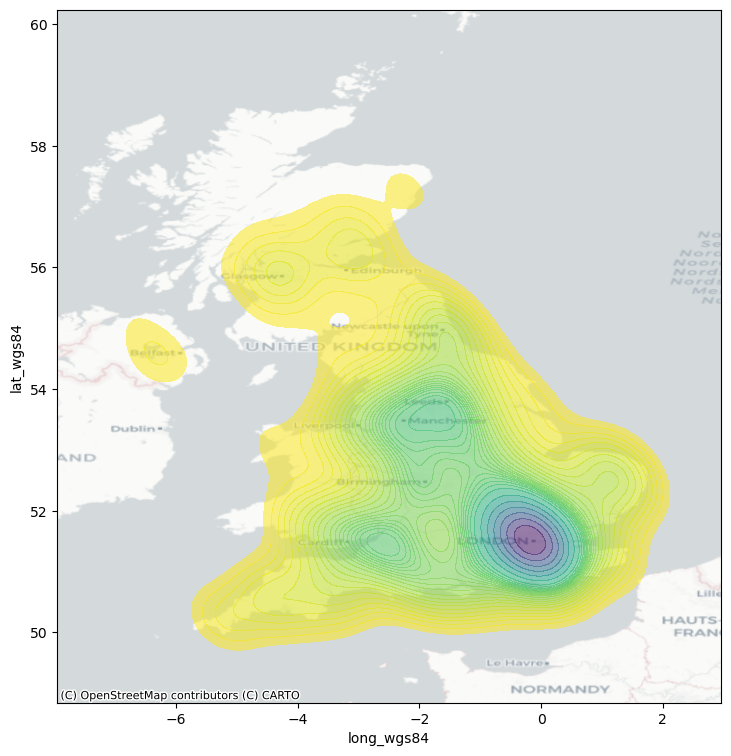

In [21]:
# Set up figure and axis
f, ax4 = plt.subplots(1, figsize=(9, 9))

# Generate and add KDE with a shading of 30 gradients
# coloured contours, 55% of transparency,
# and the reverse viridis colormap
# complete the code below
sns.kdeplot(
    x="long_wgs84",
    y="lat_wgs84",
    data=clbr_geo[clbr_geo['close_year'].isin([2023])],
    n_levels=30,
    bw_adjust=0.8,
    shade=True,
    alpha=0.55,
    cmap="viridis_r",
)

# Add basemap
contextily.add_basemap(
    ax4, crs="EPSG:4326", source=contextily.providers.CartoDB.Positron
)


In [22]:
clbr_ladpop22 = gpd.read_file('uklad_closedbranches_pop22.shp')

In [23]:
# change 'close_year' column to integer type
clbr_ladpop22['close_year'] = clbr_ladpop22['close_year'].astype(int)

In [24]:
# Filter for specific years 2017 and 2018
clbr_ladpop17_18 = clbr_ladpop22[clbr_ladpop22['close_year'].isin([2017, 2018])]

In [25]:
clbr_ladpop17_18

id         brand_full brand_shor branch_typ                    region  \
0        4  Allied Irish Bank        AIB     Branch          Northern Ireland   
1        6  Allied Irish Bank        AIB     Branch          Northern Ireland   
3        8  Allied Irish Bank        AIB     Branch          Northern Ireland   
5       10  Allied Irish Bank        AIB     Branch          Northern Ireland   
6       11  Allied Irish Bank        AIB     Branch          Northern Ireland   
...    ...                ...        ...        ...                       ...   
5527  9939     Yorkshire Bank         YB     Branch  Yorkshire and The Humber   
5528  9940     Yorkshire Bank         YB     Branch  Yorkshire and The Humber   
5532  9944     Yorkshire Bank         YB     Branch                North West   
5536  9948     Yorkshire Bank         YB     Branch  Yorkshire and The Humber   
5539  9951     Yorkshire Bank         YB     Branch  Yorkshire and The Humber   

      postcode  long_wgs84  lat_wgs84  status  close_year  ...   BNG_E  \
0      BT1 2AL   -5.926691  54.599923  Closed        2017  ...  146465   
1     BT11 9BY   -5.988669  54.573287  Closed        2017  ...  146465   
3     BT23 7HS   -5.694836  54.592691  Closed        2017  ...  164321   
5     BT30 6LP   -5.716951  54.327872  Closed        2017  ...  133006   
6     BT32 3JL   -6.268803  54.349707  Closed        2017  ...  112110   
...        ...         ...        ...     ...         ...  ...     ...   
5527   WF5 8AY   -1.577943  53.677999  Closed        2017  ...  438367   
5528   WF6 2AU   -1.420819  53.700154  Closed        2017  ...  438367   
5532   WN7 4LS   -2.519406  53.496246  Closed        2017  ...  362139   
5536  YO14 9DD   -0.288308  54.209625  Closed        2017  ...  429508   
5539  YO18 7AN   -0.775834  54.244892  Closed        2017  ...  429508   

       BNG_N     LONG      LAT                              GlobalID  \
0     529747 -5.92535  54.5985  e67d37f9-e23c-4159-a7a2-14bcf457e488   
1     529747 -5.92535  54.5985  e67d37f9-e23c-4159-a7a2-14bcf457e488   
3     524944 -5.64568  54.5641  46a86327-cf5e-452c-9ed6-fbf7dd4defdf   
5     480432 -6.08891  54.1495  d0595042-1fe1-4398-91d5-2f5954fe5be4   
6     508158 -6.43455  54.3867  a2a16c31-824f-4872-b40b-36f7c0c714bf   
...      ...      ...      ...                                   ...   
5527  418231 -1.42091  53.6592  39e643b3-92fe-42c1-ae2c-60069455f172   
5528  418231 -1.42091  53.6592  39e643b3-92fe-42c1-ae2c-60069455f172   
5532  402126 -2.57242  53.5145  07102084-bd6a-4914-b09e-38ec7d7bd101   
5536  466514 -1.55033  54.0937  2e5822ef-f8a8-4f70-8f08-f2315fee45cb   
5539  466514 -1.55033  54.0937  2e5822ef-f8a8-4f70-8f08-f2315fee45cb   

      estpop_22  estpop22_k  estpop_201  estpop11_k  \
0        348005        2617      333895        2511   
1        348005        2617      333895        2511   
3        164223         358      156943         342   
5        182634         112      172276         106   
6        220271         165      200298         150   
...         ...         ...         ...         ...   
5527     357729        1056      326433         964   
5528     357729        1056      326433         964   
5532     334110        1776      318122        1691   
5536     623501          78      601206          75   
5539     623501          78      601206          75   

                           geometry  
0     POINT (146477.883 529839.203)  
1     POINT (142308.608 527103.300)  
3     POINT (161403.717 528222.267)  
5     POINT (158418.962 498850.756)  
6     POINT (122704.284 503311.862)  
...                             ...  
5527  POINT (427976.969 420253.051)  
5528  POINT (438335.813 422790.963)  
5532  POINT (365640.009 400074.968)  
5536  POINT (511731.989 480672.961)  
5539  POINT (479870.012 483935.994)  

[1563 rows x 25 columns]

In [26]:
# save into .shp file
clbr_ladpop17_18.to_file(driver='ESRI Shapefile', filename='clbr_ladpop17_18.shp')

In [27]:
# Open the projected closed branches UK LAD pop22 shapefile
clbr_ladpop1718 = lps.io.open('clbr_ladpop17_18.shp')

# Extract points and create a PointPattern object
pp_clbr_ladpop17_18 = PointPattern(np.asarray([pnt for pnt in clbr_ladpop1718]))

# Close the shapefile
#clbr_ladpop22.close()

# Print a summary of the point pattern
pp_clbr_ladpop17_18.summary()

Point Pattern
1563 points
Bounding rectangle [(5615.327228760172,10561.990540796149), (652658.0183130404,968384.9662756368)]
Area of window: 619752355801.8245
Intensity estimate for window: 2.5219750846736495e-09
               x              y
0  146477.883243  529839.202997
1  142308.607781  527103.299615
2  161403.717328  528222.267378
3  158418.962001  498850.756038
4  122704.284388  503311.862113


<Figure size 640x480 with 0 Axes>

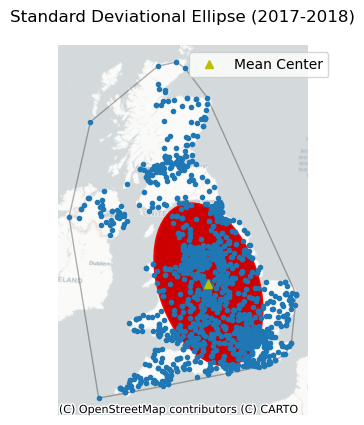

In [54]:
#Standard deviational ellipse 

# Import necessary libraries
from matplotlib.patches import Ellipse
from pylab import figure, show

# Calculate the parameters of the standard deviational ellipse for a series of point events based on their (x, y) coordinates.
# The ellipse function returns the semi-major axis (sx), semi-minor axis (sy), and the orientation angle (theta) of the ellipse.
sx, sy, theta = ellipse(pp_clbr_ladpop17_18.points)

# Convert the orientation angle `theta` from radians to degrees
# The `np.degrees` function converts an angle from radians to degrees
theta_degree = np.degrees(theta) # your code here

# Create a figure for the plot
fig = figure()

# Calculate the mean center for the point events
mc_clbr1718 = mean_center(pp_clbr_ladpop17_18.points)

# Create an ellipse centered at the mean center with the specified width, height, and rotation angle
# 'xy=mean_center(pp_clbr_ladpop22.points)' sets the center of the ellipse at the mean center of the points
# 'width=sx*2' sets the width of the ellipse to twice the semi-major axis length
# 'height=sy*2' sets the height of the ellipse to twice the semi-minor axis length
# 'angle=-theta_degree' sets the rotation angle of the ellipse (negative for clockwise rotation)
e17_18 = Ellipse(xy=mc_clbr1718, width=sx*2, height=sy*2, angle=-theta_degree) 

# Plot the point pattern 'pp_clbr_ladpop22' along with its Minimum Bounding Rectangle (MBR) and get the axis object
# 'get_ax=True' returns the axis object for further customization
# 'title='Standard Deviational Ellipse'' sets the plot title
# 'window=True' includes the MBR in the plot
ax = pp_clbr_ladpop17_18.plot(get_ax=True, title="Standard Deviational Ellipse (2017-2018)", hull=True)

# Add the ellipse to the plot
ax.add_artist(e17_18)

# Set the clipping box for the ellipse to match the axis bounding box
e17_18.set_clip_box(ax.bbox)

# Set the face color of the ellipse (e.g., a lighter red color)
e17_18.set_facecolor([0.8, 0, 0])

# Set the edge color of the ellipse (e.g., red)
e17_18.set_edgecolor([1, 0, 0])

# Set the aspect ratio of the plot to be equal
ax.set_aspect('equal')

# Plot the mean center on the same plot
# 'mc_clbr[0]' and 'mc_clbr[1]' are the x and y coordinates of the mean center, respectively
# 'y^' indicates a yellow upward-pointing triangle marker
# 'label='Mean Center'' adds a label for this marker in the legend
plt.plot(mc_clbr1718[0], mc_clbr1718[1], 'y^', label='Mean Center')

# Add basemap
contextily.add_basemap(
    ax, crs="EPSG:27700", source=contextily.providers.CartoDB.Positron
)

# Add a legend to the plot
# 'numpoints=1' specifies that each legend entry will show a single point
plt.legend(numpoints=1, loc='upper left', bbox_to_anchor=(0.5,1))
plt.axis('off') #don't plot the axes (bounding box)

#save as file
plt.savefig("figures/stddev_clbr17_18.png", dpi=300, bbox_inches='tight', facecolor='white')

# Show the plot
# This command will display the plot with the point pattern, mean center, and standard deviational ellipse
plt.show()

In [29]:
print("Mean Centre for UK bank branch closures in 2017-18 is: " + "(" + str(mc_clbr1718[0]) +" , " + str(mc_clbr1718[1])+ ")")

Mean Centre for UK bank branch closures in 2017-18 is: (403101.4368793224 , 334440.6749385895)


In [30]:
# Filter for specific years 2022 and 2023
clbr_ladpop22_23 = clbr_ladpop22[clbr_ladpop22['close_year'].isin([2022, 2023])]

In [31]:
# save into .shp file
clbr_ladpop22_23.to_file(driver='ESRI Shapefile', filename='clbr_ladpop22_23.shp')

In [32]:
# Open the projected closed branches UK LAD pop22 shapefile
clbr_ladpop2223 = lps.io.open('clbr_ladpop22_23.shp')

# Extract points and create a PointPattern object
pp_clbr_ladpop22_23 = PointPattern(np.asarray([pnt for pnt in clbr_ladpop2223]))

# Close the shapefile
#clbr_ladpop22.close()

# Print a summary of the point pattern
pp_clbr_ladpop22_23.summary()

Point Pattern
1486 points
Bounding rectangle [(49305.53376476589,27476.61852553817), (652634.0025342312,1141409.3754792984)]
Area of window: 672067344565.0612
Intensity estimate for window: 2.2110879393518043e-09
               x              y
0  393824.055135  806014.460272
1  389360.776141  802940.774664
2  388689.055546  812335.950841
3  337081.058614  795674.666355
4  315178.256070  791476.725409


<Figure size 640x480 with 0 Axes>

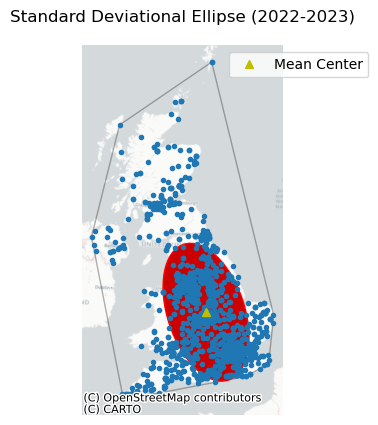

In [53]:
#Standard deviational ellipse 

# Import necessary libraries
from matplotlib.patches import Ellipse
from pylab import figure, show

# Calculate the parameters of the standard deviational ellipse for a series of point events based on their (x, y) coordinates.
# The ellipse function returns the semi-major axis (sx), semi-minor axis (sy), and the orientation angle (theta) of the ellipse.
sx, sy, theta = ellipse(pp_clbr_ladpop22_23.points)

# Convert the orientation angle `theta` from radians to degrees
# The `np.degrees` function converts an angle from radians to degrees
theta_degree = np.degrees(theta)

# Create a figure for the plot
#fig = figure()
fig1 = figure()

# Calculate the mean center for the point events
mc_clbr2223 = mean_center(pp_clbr_ladpop22_23.points)

# Create an ellipse centered at the mean center with the specified width, height, and rotation angle
# 'xy=mean_center(pp_clbr_ladpop22.points)' sets the center of the ellipse at the mean center of the points
# 'width=sx*2' sets the width of the ellipse to twice the semi-major axis length
# 'height=sy*2' sets the height of the ellipse to twice the semi-minor axis length
# 'angle=-theta_degree' sets the rotation angle of the ellipse (negative for clockwise rotation)
e22_23 = Ellipse(xy=mc_clbr2223, width=sx*2, height=sy*2, angle=-theta_degree) 

# Plot the point pattern 'pp_clbr_ladpop22' along with its Minimum Bounding Rectangle (MBR) and get the axis object
# 'get_ax=True' returns the axis object for further customization
# 'title='Standard Deviational Ellipse'' sets the plot title
# 'window=True' includes the MBR in the plot
ax = pp_clbr_ladpop22_23.plot(get_ax=True, title="Standard Deviational Ellipse (2022-2023)", hull=True)

# Add the ellipse to the plot
ax.add_artist(e22_23)

# Set the clipping box for the ellipse to match the axis bounding box
e22_23.set_clip_box(ax.bbox)

# Set the face color of the ellipse (e.g., a lighter red color)
e22_23.set_facecolor([0.8, 0, 0])

# Set the edge color of the ellipse (e.g., red)
e22_23.set_edgecolor([1, 0, 0])

# Set the aspect ratio of the plot to be equal
ax.set_aspect('equal')

# Plot the mean center on the same plot
# 'mc_clbr[0]' and 'mc_clbr[1]' are the x and y coordinates of the mean center, respectively
# 'y^' indicates a yellow upward-pointing triangle marker
# 'label='Mean Center'' adds a label for this marker in the legend
plt.plot(mc_clbr2223[0], mc_clbr2223[1], 'y^', label='Mean Center')

# Add basemap
contextily.add_basemap(
   ax, crs="EPSG:27700", source=contextily.providers.CartoDB.Positron
)

# Add a legend to the plot
# 'numpoints=1' specifies that each legend entry will show a single point
plt.legend(numpoints=1, loc='upper left', bbox_to_anchor=(0.7,1))
plt.axis('off') #don't plot the axes (bounding box))

plt.axis('off') #don't plot the axes (bounding box)

#save as file
plt.savefig("figures/stddev_clbr22_23.png", dpi=300, bbox_inches='tight', facecolor='white')

# Show the plot
plt.show()

In [34]:
print("Mean Centre for UK bank branch closures in 2022-23 is: " + "(" + str(mc_clbr2223[0]) +" , " + str(mc_clbr2223[1])+ ")")

Mean Centre for UK bank branch closures in 2022-23 is: (428951.88320308697 , 312040.62912075734)


In [35]:
banks_gdf = gpd.read_file("geolytix_uk_banks.shp") #read created shp

In [36]:
banks_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 11660 entries, 0 to 11659
Data columns (total 26 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   id          11660 non-null  int64   
 1   brand_full  11660 non-null  object  
 2   brand_shor  11660 non-null  object  
 3   branch_nam  11540 non-null  object  
 4   branch_typ  11660 non-null  object  
 5   add_one     10846 non-null  object  
 6   add_two     4137 non-null   object  
 7   suburb      8021 non-null   object  
 8   town        11235 non-null  object  
 9   region      10622 non-null  object  
 10  postcode    11484 non-null  object  
 11  long_wgs84  11660 non-null  float64 
 12  lat_wgs84   11660 non-null  float64 
 13  hours_mond  5882 non-null   object  
 14  hours_tues  5792 non-null   object  
 15  hours_wedn  5684 non-null   object  
 16  hours_thur  5692 non-null   object  
 17  hours_frid  5836 non-null   object  
 18  hours_satu  2032 non-null   object  
 

In [37]:
#create subset of gdf for open (status) branches (branch type)
open_branches = banks_gdf[(banks_gdf['branch_typ'] == 'Branch') & (banks_gdf['status'] == 'Open')][['id', 'brand_full', 'brand_shor', 'branch_typ', 'region', 'postcode', 'long_wgs84', 'lat_wgs84', 'status', 'close_year', 'po_dist', 'geometry']]

In [38]:
open_branches.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 4275 entries, 0 to 11659
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   id          4275 non-null   int64   
 1   brand_full  4275 non-null   object  
 2   brand_shor  4275 non-null   object  
 3   branch_typ  4275 non-null   object  
 4   region      4019 non-null   object  
 5   postcode    4272 non-null   object  
 6   long_wgs84  4275 non-null   float64 
 7   lat_wgs84   4275 non-null   float64 
 8   status      4275 non-null   object  
 9   close_year  0 non-null      float64 
 10  po_dist     4275 non-null   int64   
 11  geometry    4275 non-null   geometry
dtypes: float64(3), geometry(1), int64(2), object(6)
memory usage: 434.2+ KB


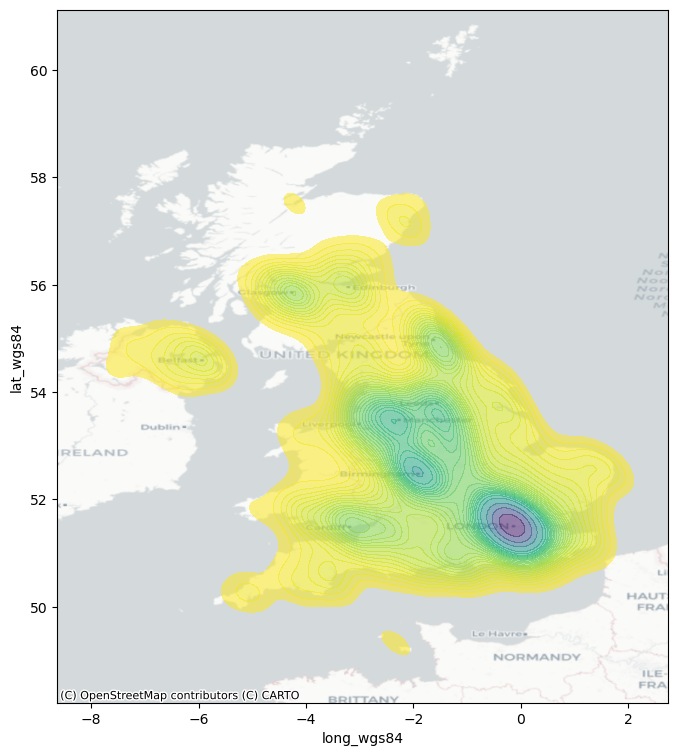

In [39]:
# Set up figure and axis
f, ax5 = plt.subplots(1, figsize=(9, 9))

# Generate and add KDE with a shading of 30 gradients
# coloured contours, 55% of transparency,
# and the reverse viridis colormap
# complete the code below
sns.kdeplot(
    x="long_wgs84",
    y="lat_wgs84",
    data=open_branches,
    n_levels=30,
    bw_adjust=0.8,
    shade=True,
    alpha=0.55,
    cmap="viridis_r",
)

# Add basemap
contextily.add_basemap(
    ax5, crs="EPSG:4326", source=contextily.providers.CartoDB.Positron
)


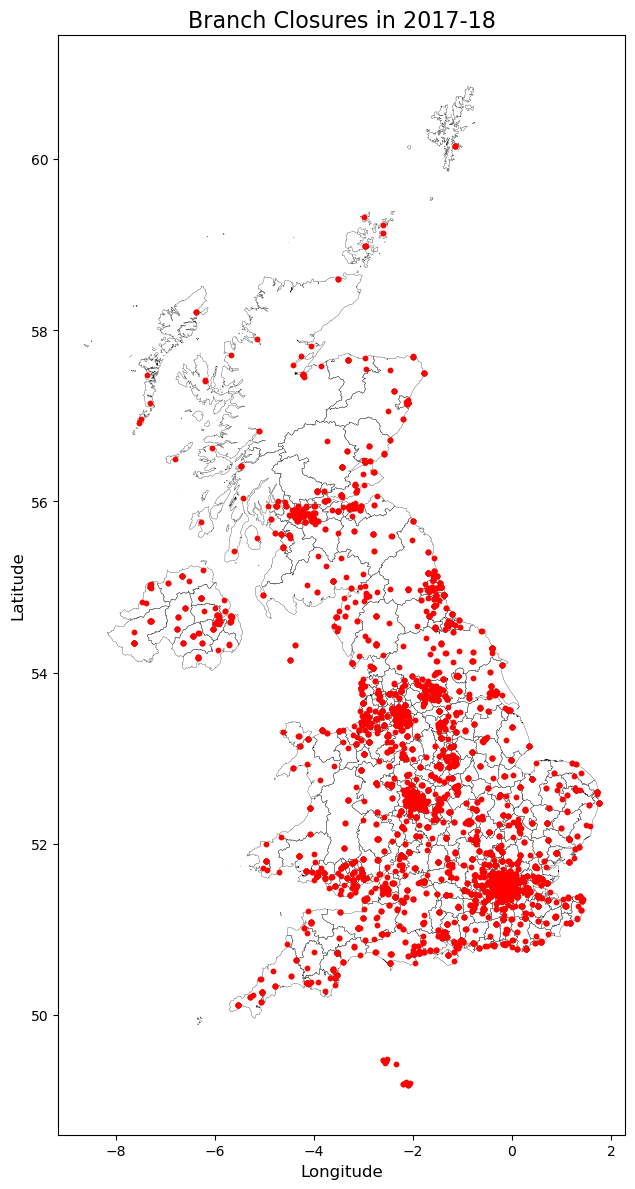

In [40]:
# Plot using Matplotlib
fig, ax6 = plt.subplots(figsize=(12, 12))

#Plot the LAD boundaries
uklad_geo.plot(ax=ax6, edgecolor='black', facecolor='none', linewidth=0.2)

# Plot the points
open_branches.plot(ax=ax6, color='red', markersize=10)


# Add title and axis labels
ax6.set_title("Branch Closures in 2017-18", fontsize=16)
ax6.set_xlabel("Longitude", fontsize=12)
ax6.set_ylabel("Latitude", fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

In [41]:
uklad_sums_pop22 = gpd.read_file("sums_br_uklad_base.shp")

In [42]:
uklad_sums_pop22

LAD24CD               LAD24NM        LAD24NMW   BNG_E   BNG_N     LONG  \
0    E06000001            Hartlepool            None  447161  531473 -1.27017   
1    E06000002         Middlesbrough            None  451141  516887 -1.21099   
2    E06000003  Redcar and Cleveland            None  464330  519596 -1.00656   
3    E06000004      Stockton-on-Tees            None  444940  518179 -1.30664   
4    E06000005            Darlington            None  428029  515648 -1.56835   
..         ...                   ...             ...     ...     ...      ...   
356  W06000020               Torfaen         Torfaen  327459  200480 -3.05101   
357  W06000021         Monmouthshire       Sir Fynwy  337812  209231 -2.90280   
358  W06000022               Newport       Casnewydd  337897  187432 -2.89769   
359  W06000023                 Powys           Powys  302329  273254 -3.43531   
360  W06000024        Merthyr Tydfil  Merthyr Tudful  305916  206404 -3.36425   

         LAT                              GlobalID  estpop_22  estpop22_k  \
0    54.6761  3f58aa35-9ea6-4001-a80f-8aab0e41313f      93861        1002   
1    54.5447  c5bc1c3e-111f-46db-8e41-362fbbc78d30     148285        2752   
2    54.5675  29afa1cb-8719-44c2-9906-38bc7bae2981     137175         560   
3    54.5569  8ebb86c0-86bb-466e-ae7e-a832eeb755ff     199966         976   
4    54.5353  bf2173db-02e1-4b58-9617-e775100f58ec     109469         554   
..       ...                                   ...        ...         ...   
356  51.6984  0cf05ad3-d5b4-4034-aef6-391a4f42fdb9      92860         739   
357  51.7783  46cfbd32-dcb3-4da1-a166-0f149baa4e24      93886         111   
358  51.5823  2d467913-8823-4be7-9178-ced94fc0673a     161506         848   
359  52.3486  1f185fde-3f8c-4e60-b45d-4fb0379a9a51     133891          26   
360  51.7484  9925511b-44e7-4753-8da5-72e7e510b305      58883         528   

     estpop_201  estpop11_k  total_bran  closed_bra  open_branc  closing_br  \
0         92088         983          10           4           6           0   
1        138368        2568          18           7          11           0   
2        135164         552          19          14           5           0   
3        191824         936          27          12          15           0   
4        105584         535          14           3          11           0   
..          ...         ...         ...         ...         ...         ...   
356       91190         725          17           6          11           0   
357       91508         108          30          15          15           0   
358      145785         766          19           6          13           0   
359      133071          26          46          33          13           0   
360       58851         528           7           1           6           0   

     clbr_prop                                           geometry  
0     0.400000  POLYGON ((448964.105 536757.184, 448986.025 53...  
1     0.388889  POLYGON ((451894.299 521145.303, 453997.697 51...  
2     0.736842  POLYGON ((478232.947 518788.803, 477689.303 51...  
3     0.444444  POLYGON ((452243.536 526335.188, 451711.300 52...  
4     0.214286  POLYGON ((436388.002 522354.197, 437351.702 52...  
..         ...                                                ...  
356   0.352941  POLYGON ((333723.000 192653.903, 331617.797 19...  
357   0.500000  MULTIPOLYGON (((354639.302 191757.499, 354620....  
358   0.315789  POLYGON ((343091.268 184213.081, 339999.991 18...  
359   0.717391  POLYGON ((322891.603 333139.299, 323688.497 33...  
360   0.142857  POLYGON ((308057.304 211036.201, 308367.104 20...  

[361 rows x 18 columns]

In [43]:
# Calculate closed branches per 10,000 people
uklad_sums_pop22['clbr_per_10k'] = (uklad_sums_pop22['closed_bra'] / uklad_sums_pop22['estpop_22']) * 10000

# Calculate open branches per 10,000 people
uklad_sums_pop22['opbr_per_10k'] = (uklad_sums_pop22['open_branc'] / uklad_sums_pop22['estpop_22']) * 10000

In [44]:
uklad_sums_pop22

LAD24CD               LAD24NM        LAD24NMW   BNG_E   BNG_N     LONG  \
0    E06000001            Hartlepool            None  447161  531473 -1.27017   
1    E06000002         Middlesbrough            None  451141  516887 -1.21099   
2    E06000003  Redcar and Cleveland            None  464330  519596 -1.00656   
3    E06000004      Stockton-on-Tees            None  444940  518179 -1.30664   
4    E06000005            Darlington            None  428029  515648 -1.56835   
..         ...                   ...             ...     ...     ...      ...   
356  W06000020               Torfaen         Torfaen  327459  200480 -3.05101   
357  W06000021         Monmouthshire       Sir Fynwy  337812  209231 -2.90280   
358  W06000022               Newport       Casnewydd  337897  187432 -2.89769   
359  W06000023                 Powys           Powys  302329  273254 -3.43531   
360  W06000024        Merthyr Tydfil  Merthyr Tudful  305916  206404 -3.36425   

         LAT                              GlobalID  estpop_22  estpop22_k  \
0    54.6761  3f58aa35-9ea6-4001-a80f-8aab0e41313f      93861        1002   
1    54.5447  c5bc1c3e-111f-46db-8e41-362fbbc78d30     148285        2752   
2    54.5675  29afa1cb-8719-44c2-9906-38bc7bae2981     137175         560   
3    54.5569  8ebb86c0-86bb-466e-ae7e-a832eeb755ff     199966         976   
4    54.5353  bf2173db-02e1-4b58-9617-e775100f58ec     109469         554   
..       ...                                   ...        ...         ...   
356  51.6984  0cf05ad3-d5b4-4034-aef6-391a4f42fdb9      92860         739   
357  51.7783  46cfbd32-dcb3-4da1-a166-0f149baa4e24      93886         111   
358  51.5823  2d467913-8823-4be7-9178-ced94fc0673a     161506         848   
359  52.3486  1f185fde-3f8c-4e60-b45d-4fb0379a9a51     133891          26   
360  51.7484  9925511b-44e7-4753-8da5-72e7e510b305      58883         528   

     estpop_201  estpop11_k  total_bran  closed_bra  open_branc  closing_br  \
0         92088         983          10           4           6           0   
1        138368        2568          18           7          11           0   
2        135164         552          19          14           5           0   
3        191824         936          27          12          15           0   
4        105584         535          14           3          11           0   
..          ...         ...         ...         ...         ...         ...   
356       91190         725          17           6          11           0   
357       91508         108          30          15          15           0   
358      145785         766          19           6          13           0   
359      133071          26          46          33          13           0   
360       58851         528           7           1           6           0   

     clbr_prop                                           geometry  \
0     0.400000  POLYGON ((448964.105 536757.184, 448986.025 53...   
1     0.388889  POLYGON ((451894.299 521145.303, 453997.697 51...   
2     0.736842  POLYGON ((478232.947 518788.803, 477689.303 51...   
3     0.444444  POLYGON ((452243.536 526335.188, 451711.300 52...   
4     0.214286  POLYGON ((436388.002 522354.197, 437351.702 52...   
..         ...                                                ...   
356   0.352941  POLYGON ((333723.000 192653.903, 331617.797 19...   
357   0.500000  MULTIPOLYGON (((354639.302 191757.499, 354620....   
358   0.315789  POLYGON ((343091.268 184213.081, 339999.991 18...   
359   0.717391  POLYGON ((322891.603 333139.299, 323688.497 33...   
360   0.142857  POLYGON ((308057.304 211036.201, 308367.104 20...   

     clbr_per_10k  opbr_per_10k  
0        0.426162      0.639243  
1        0.472064      0.741815  
2        1.020594      0.364498  
3        0.600102      0.750128  
4        0.274050      1.004851  
..            ...           ...  
356      0.646134      1.184579  
357      1.597682      1.597682  
358      0.371503      0.

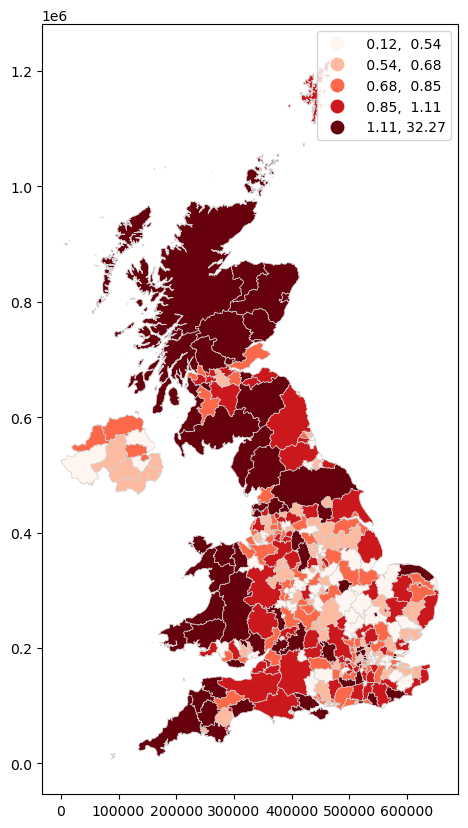

In [45]:
fig, ax7 = plt.subplots(1, figsize=(10,10))
uklad_sums_pop22.plot(column='clbr_per_10k', cmap='Reds', 
        scheme='quantiles', legend=True,
        edgecolor="lightgrey", linewidth=0.5, ax=ax7)
plt.show()

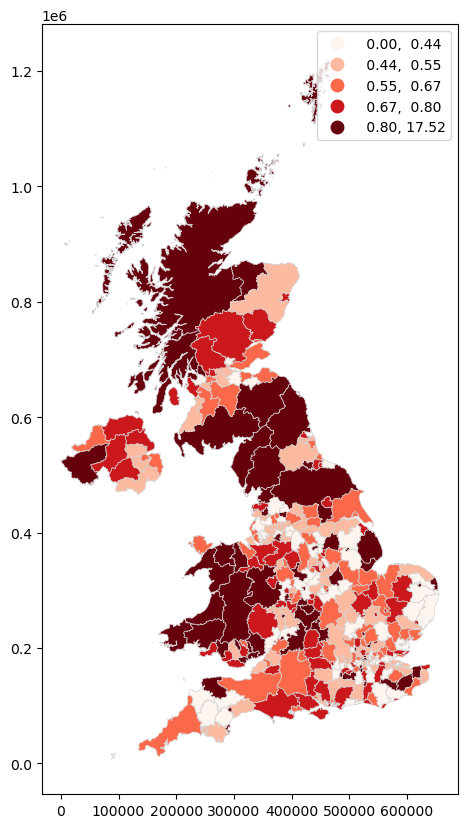

In [46]:
fig, ax8 = plt.subplots(1, figsize=(10,10))
uklad_sums_pop22.plot(column='opbr_per_10k', cmap='Reds', 
        scheme='quantiles', legend=True,
        edgecolor="lightgrey", linewidth=0.5, ax=ax8)
plt.show()

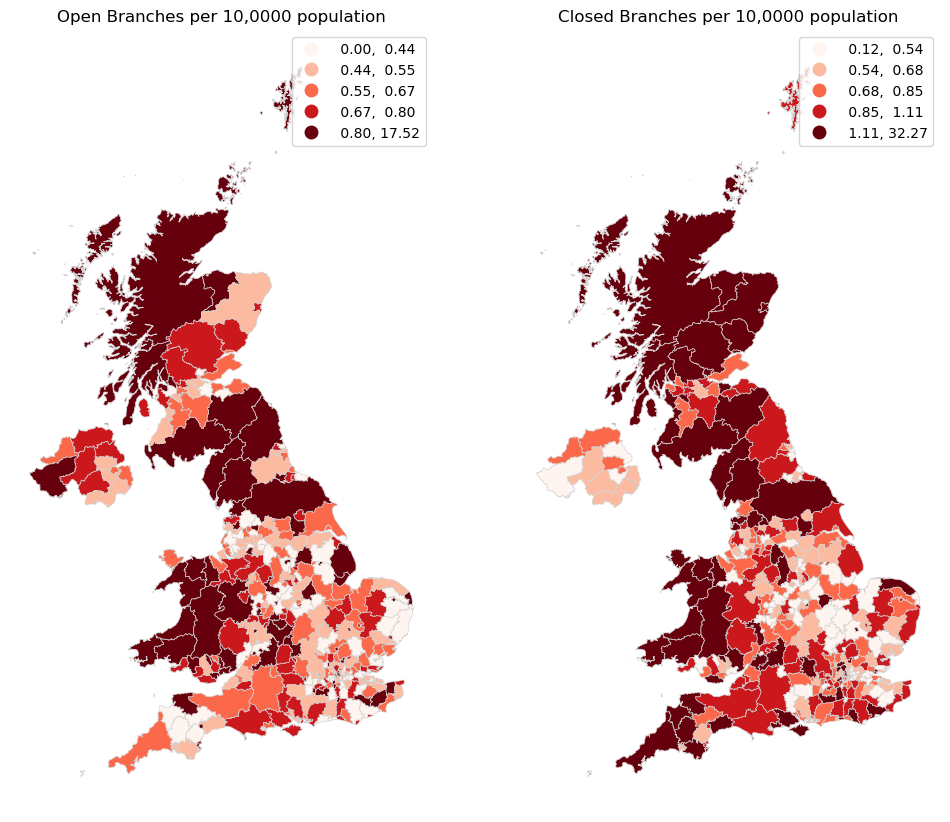

In [47]:
fig, axs = plt.subplots(1,2, figsize=(12, 12))

uklad_sums_pop22.plot(column='opbr_per_10k', cmap='Reds', 
        scheme='quantiles', legend=True,
        edgecolor="lightgrey", linewidth=0.5, ax=axs[0])

uklad_sums_pop22.plot(column='clbr_per_10k', cmap='Reds', 
        scheme='quantiles', legend=True,
        edgecolor="lightgrey", linewidth=0.5, ax=axs[1])

axs[0].set_axis_off()
axs[0].set_title("Open Branches per 10,0000 population")

axs[1].set_axis_off()
axs[1].set_title("Closed Branches per 10,0000 population")

plt.show()

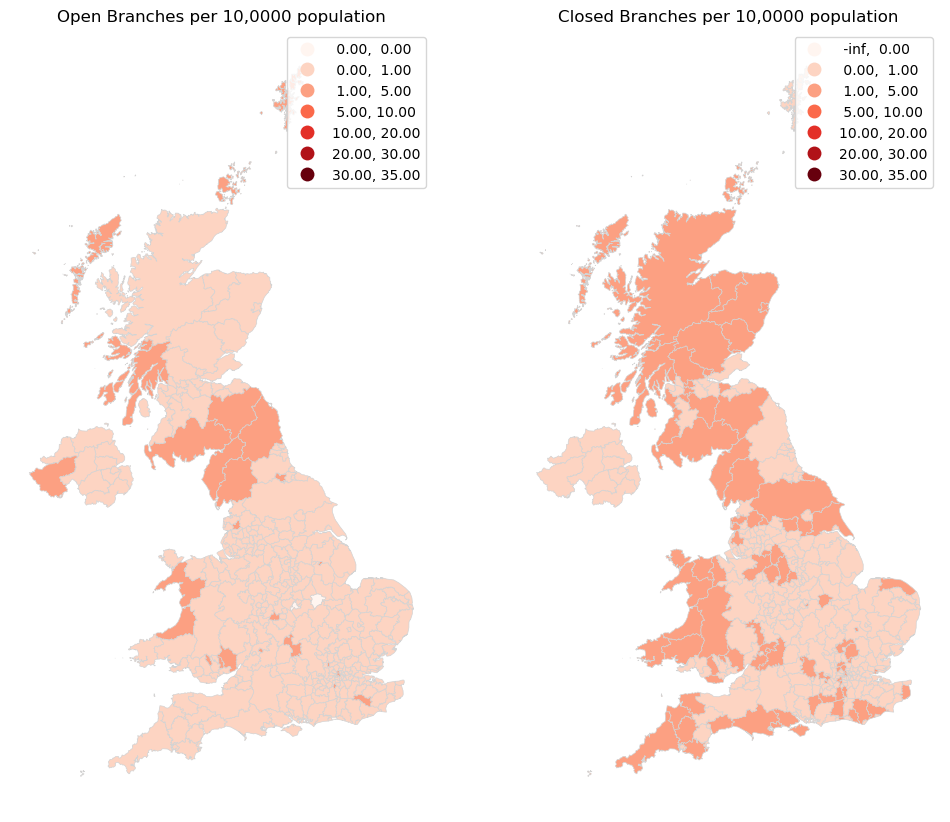

In [48]:
fig, axs1 = plt.subplots(1,2, figsize=(12, 12))

# Define bins
bins = [0, 1, 5, 10, 20, 30, 35]

uklad_sums_pop22.plot(column='opbr_per_10k', cmap='Reds', 
                      scheme='UserDefined', classification_kwds={'bins': bins}, 
                      legend=True, edgecolor="lightgrey", linewidth=0.5, ax=axs1[0])

uklad_sums_pop22.plot(column='clbr_per_10k', cmap='Reds', 
                      scheme='UserDefined', 
                      classification_kwds={'bins': bins}, legend=True, 
                      edgecolor="lightgrey", linewidth=0.5, ax=axs1[1])

axs1[0].set_axis_off()
axs1[0].set_title("Open Branches per 10,0000 population")

axs1[1].set_axis_off()
axs1[1].set_title("Closed Branches per 10,0000 population")

plt.show()

In [49]:
print(uklad_sums_pop22['opbr_per_10k'].describe())
print(uklad_sums_pop22['clbr_per_10k'].describe())

count    361.000000
mean       0.686482
std        0.939879
min        0.000000
25%        0.470851
50%        0.600450
75%        0.766801
max       17.516364
Name: opbr_per_10k, dtype: float64
count    361.000000
mean       0.938248
std        1.712422
min        0.122620
25%        0.578944
50%        0.761005
75%        1.017549
max       32.266986
Name: clbr_per_10k, dtype: float64
